In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tushar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os
os.getcwd()

'C:\\Users\\Tushar\\Documents'

In [61]:
df=pd.read_csv('C:\\Users\\Tushar\\Documents\\Twitter_Data.csv')

In [62]:
df.shape

(162980, 2)

In [22]:
##Some basic EDA

In [63]:
df.head()

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

In [64]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [65]:
df=df.dropna().reset_index()

In [66]:
df.shape

(162969, 3)

In [67]:
df['category'].value_counts(normalize=True)

 1.0    0.443330
 0.0    0.338782
-1.0    0.217888
Name: category, dtype: float64

### Cleaning Text

In [68]:
import re
def clean_tweets(tweet):
    
    # remove URL
    tweet = re.sub(r"http\S+", "", tweet)
    
    # Remove usernames
    tweet = re.sub(r"@[^\s]+[\s]?",'',tweet)
    
    # remove special characters 
    tweet = re.sub('[^ a-zA-Z0-9]', '', tweet)
    
    # remove Numbers
    tweet = re.sub('[0-9]', '', tweet)
    
    return tweet

In [69]:
df['clean_text'] = df['clean_text'].apply(clean_tweets)

### Tweet Category wise distribution

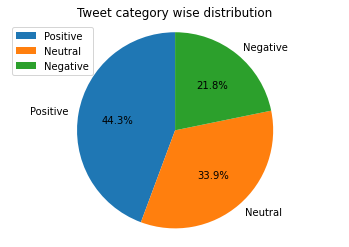

In [70]:
labels = ['Positive','Neutral','Negative']
sizes = df['category'].value_counts(normalize=True).values.tolist()
plt.pie(sizes, labels=labels, autopct='%1.1f%%',startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(loc=2)
plt.title('Tweet category wise distribution')
plt.show()

## Taking a glance through all the repeatedly occuring words

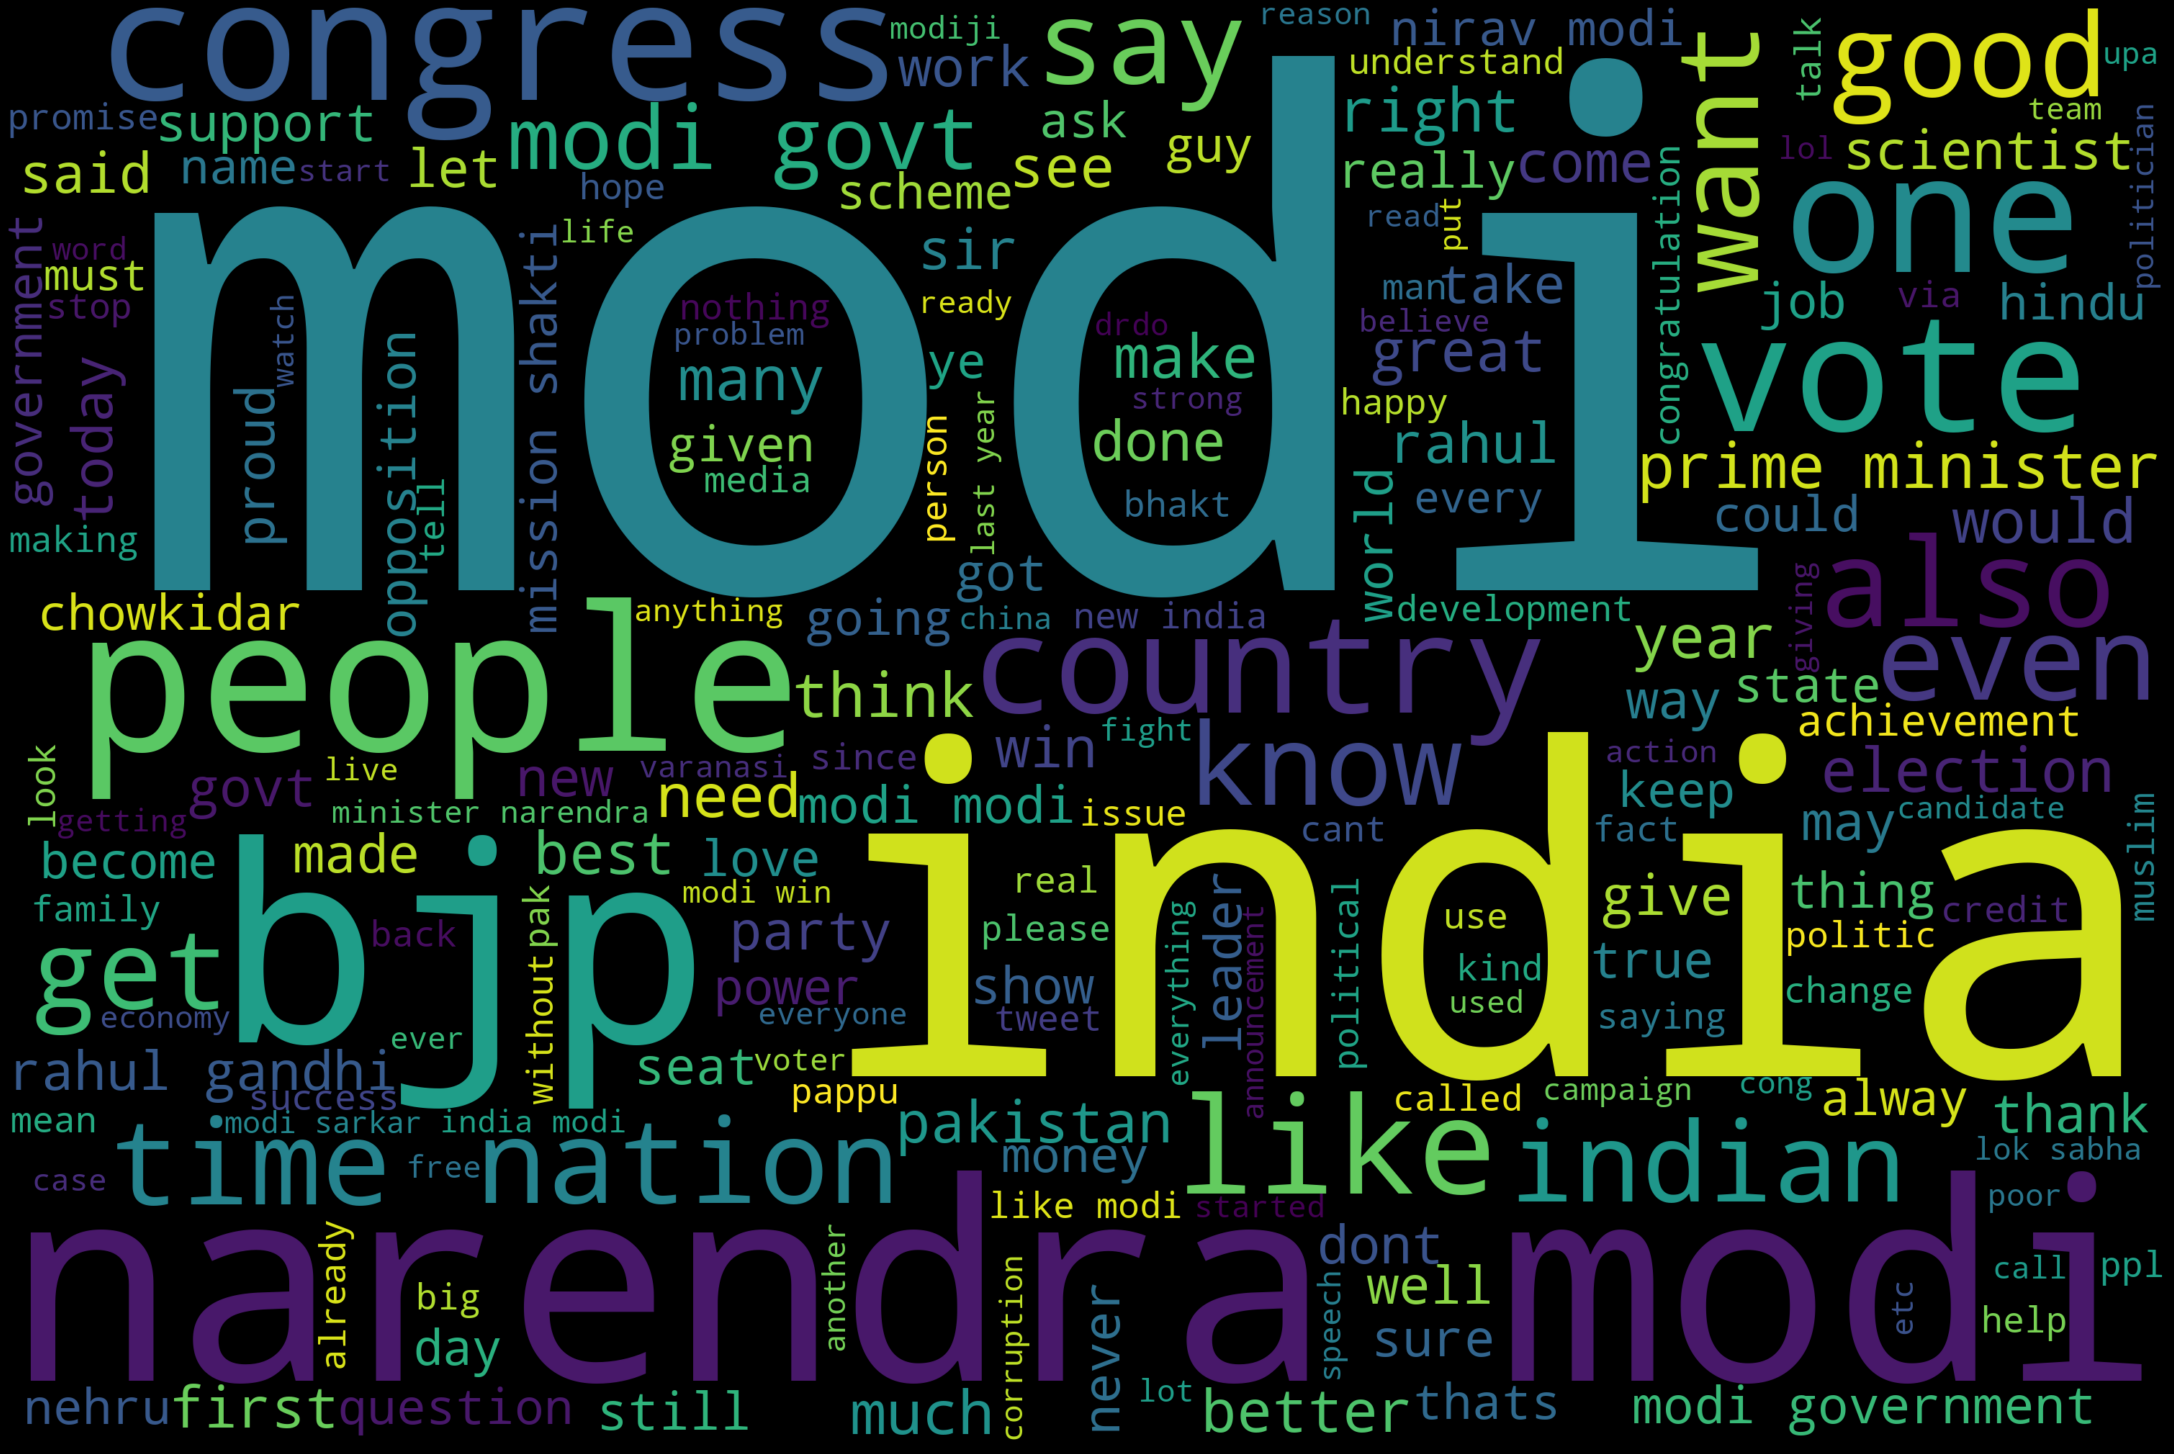

In [71]:
##positive tweets
text = ''
for tweet in df[df['category'] == 1.0]['clean_text']:
    text += f" {tweet}"
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(figsize=(30,30), facecolor='k',edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

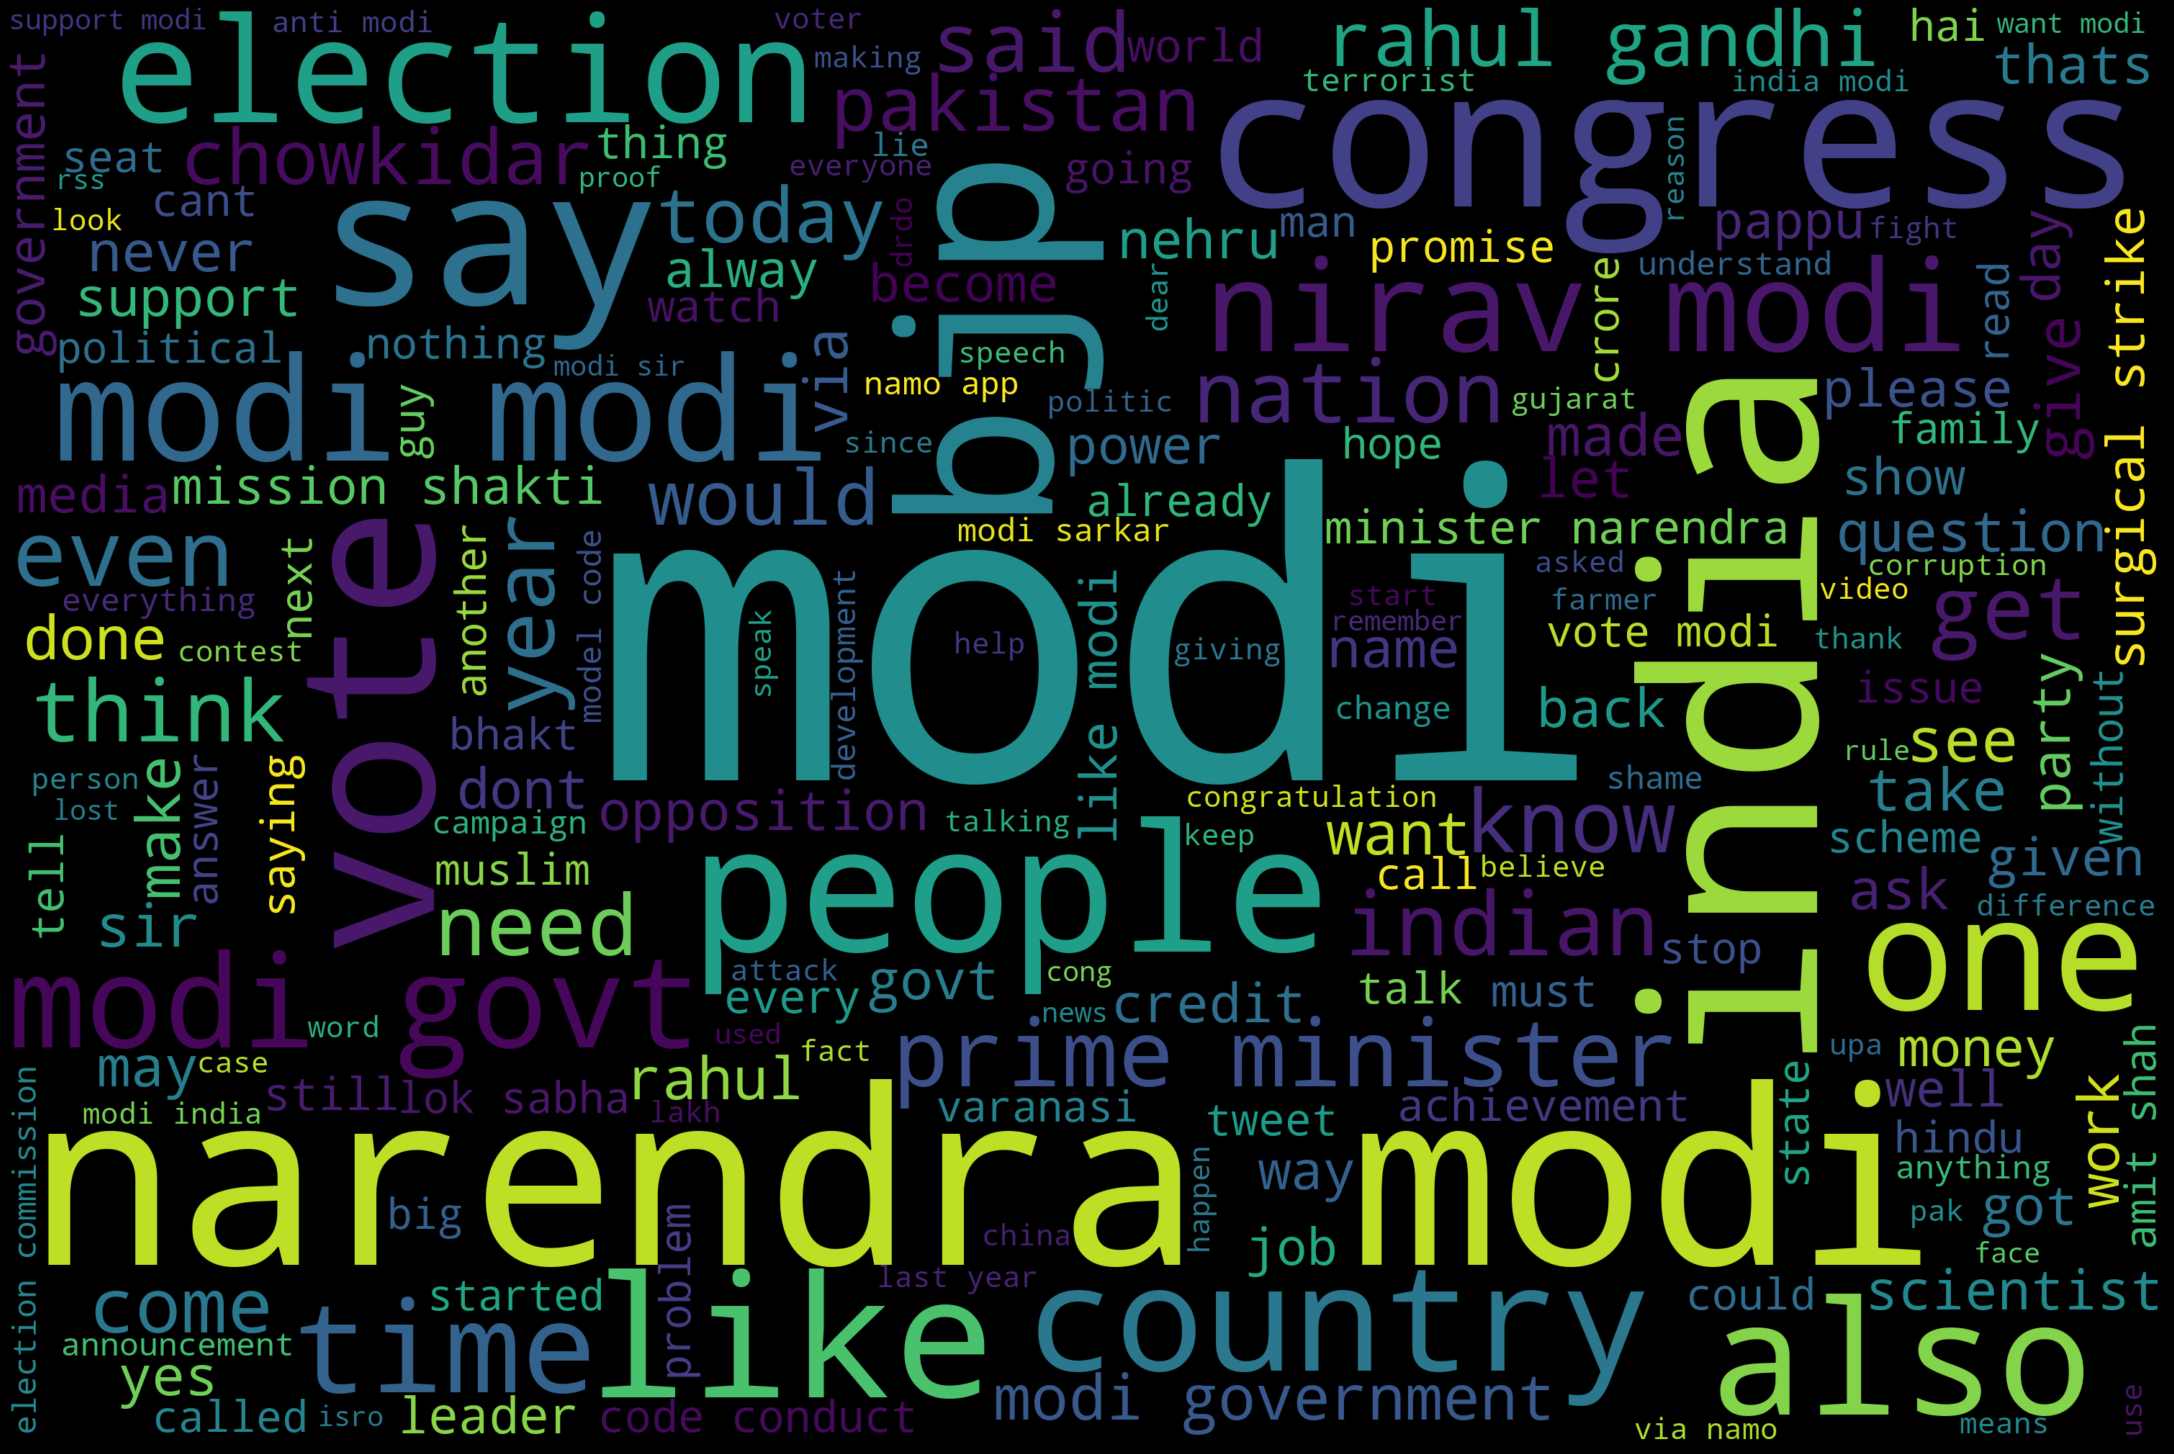

In [14]:
##Neutral tweets
text = ''
for tweet in df[df['category'] == 0.0]['clean_text']:
    text += f" {tweet}"
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(figsize=(30,30), facecolor='k',edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

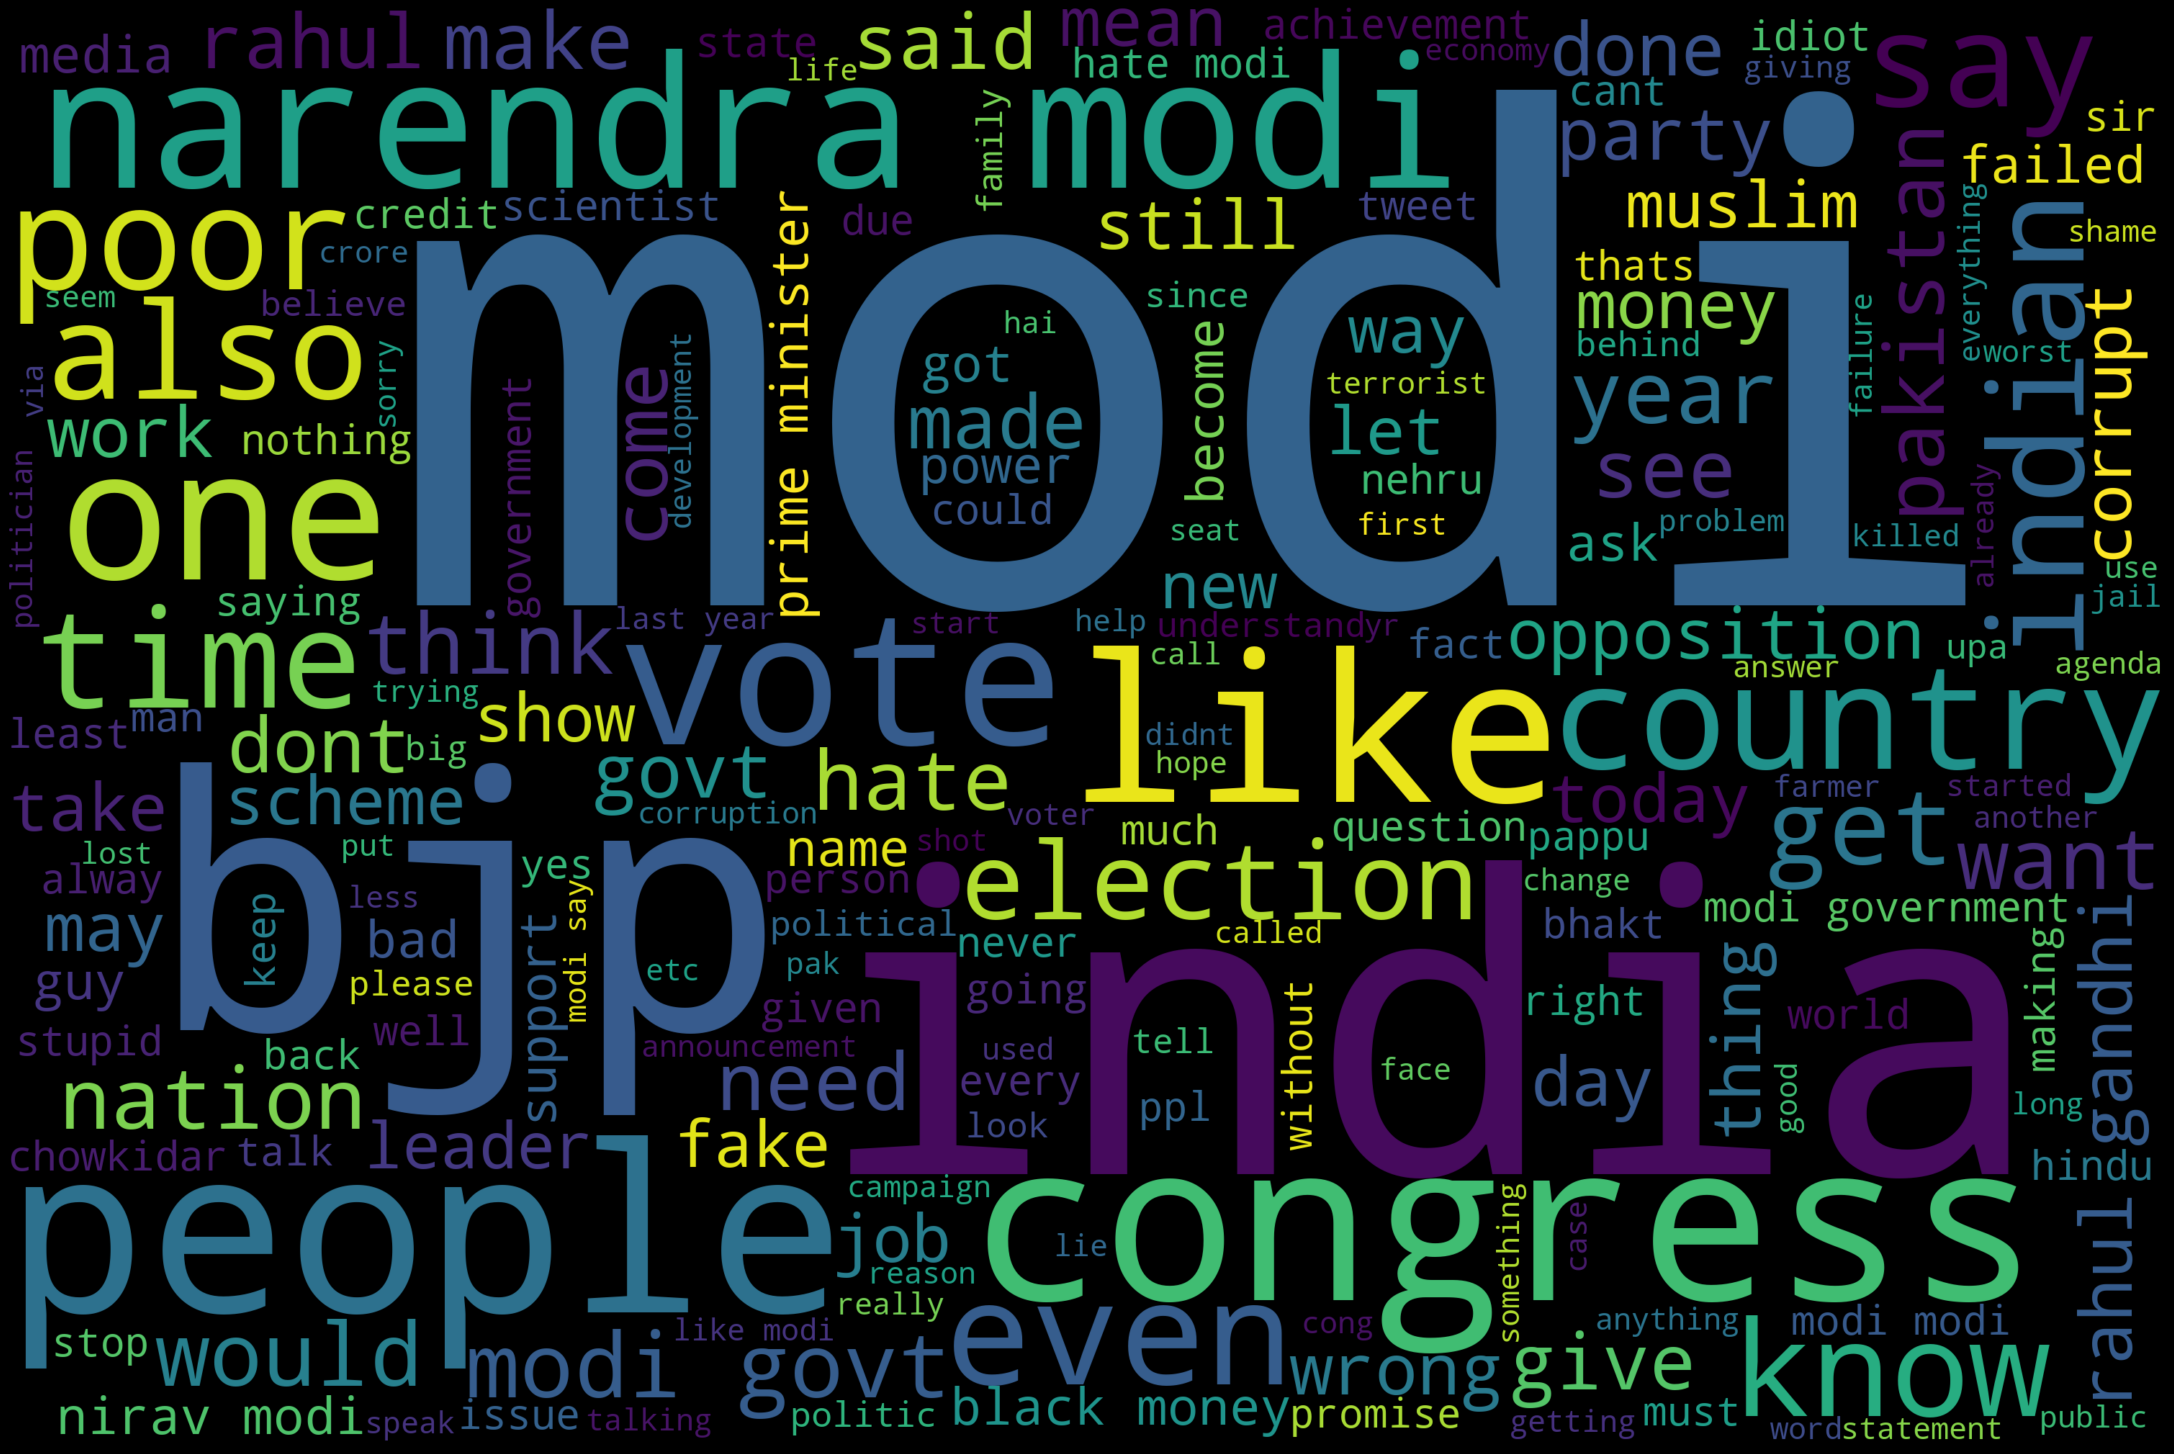

In [15]:
##Negative tweets
text = ''
for tweet in df[df['category'] == -1.0]['clean_text']:
    text += f" {tweet}"
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(figsize=(30,30), facecolor='k',edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [150]:
## Train Test Split
train_data=df

In [151]:
train_data.rename(columns={'category':'emotion','clean_text':'tweet'},inplace=True)

In [152]:
train_data['emotion']=np.where(train_data['emotion']==1,'positive',np.where(train_data['emotion']==-1,'negative','neutral')) 

## Tokenization & stemming

In [153]:
# Function which directly tokenize the tweet data
from nltk.tokenize import TweetTokenizer

tt = TweetTokenizer()
train_data['tweet'].apply(tt.tokenize)

0         [when, modi, promised, minimum, government, ma...
1         [talk, all, the, nonsense, and, continue, all,...
2         [what, did, just, say, vote, for, modi, welcom...
3         [asking, his, supporters, prefix, chowkidar, t...
4         [answer, who, among, these, the, most, powerfu...
                                ...                        
162964    [why, these, crores, paid, neerav, modi, not, ...
162965    [dear, rss, terrorist, payal, gawar, what, abo...
162966    [did, you, cover, her, interaction, forum, whe...
162967    [there, big, project, came, into, india, modi,...
162968    [have, you, ever, listen, about, like, gurukul...
Name: tweet, Length: 162969, dtype: object

In [154]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

In [155]:
def tokenize(text):
    return word_tokenize(text)

def stemming(words):
    stem_words = []
    for w in words:
        w = ps.stem(w)
        stem_words.append(w)
    
    return stem_words

In [156]:
# apply tokenize function
train_data['text'] = train_data['tweet'].apply(tokenize)

In [157]:
# apply steming function
train_data['tokenized'] = train_data['text'].apply(stemming)

In [158]:
train_data.head()

index                                              tweet   emotion  \
0      0  when modi promised minimum government maximum ...  negative   
1      1  talk all the nonsense and continue all the dra...   neutral   
2      2  what did just say vote for modi  welcome bjp t...  positive   
3      3  asking his supporters prefix chowkidar their n...  positive   
4      4  answer who among these the most powerful world...  positive   

                                                text  \
0  [when, modi, promised, minimum, government, ma...   
1  [talk, all, the, nonsense, and, continue, all,...   
2  [what, did, just, say, vote, for, modi, welcom...   
3  [asking, his, supporters, prefix, chowkidar, t...   
4  [answer, who, among, these, the, most, powerfu...   

                                           tokenized  
0  [when, modi, promis, minimum, govern, maximum,...  
1  [talk, all, the, nonsens, and, continu, all, t...  
2  [what, did, just, say, vote, for, modi, welcom...  
3  [ask, hi, support, prefix, chowkidar, their, n...  
4  [answer, who, among, these, the, most, power, ...

In [159]:
words = Counter()
for idx in train_data.index:
    words.update(train_data.loc[idx, "text"])

words.most_common(5)

[('modi', 152904),
 ('the', 104037),
 ('and', 66818),
 ('for', 52271),
 ('you', 38529)]

In [160]:
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tushar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [161]:
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(5)

[('modi', 152904),
 ('not', 30191),
 ('india', 28499),
 ('bjp', 14333),
 ('people', 13742)]

In [162]:
def word_list(processed_data):
    #print(processed_data)
    min_occurrences=3 
    max_occurences=500 
    stopwords=nltk.corpus.stopwords.words("english")
    whitelist = ["n't","not"]
    wordlist = []
    
    whitelist = whitelist if whitelist is None else whitelist
    #print(whitelist)
    '''
    import os
    if os.path.isfile("wordlist.csv"):
        word_df = pd.read_csv("wordlist.csv")
        word_df = word_df[word_df["occurrences"] > min_occurrences]
        wordlist = list(word_df.loc[:, "word"])
        #return
    '''
    words = Counter()
    for idx in processed_data.index:
        words.update(processed_data.loc[idx, "text"])

    for idx, stop_word in enumerate(stopwords):
        if stop_word not in whitelist:
            del words[stop_word]
    #print(words)

    word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                 "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                           columns=["word", "occurrences"])
    #print(word_df)
    word_df.to_csv("wordlist.csv", index_label="idx")
    wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]
    #print(wordlist)


In [163]:
word_list(train_data)

In [164]:
words = pd.read_csv("wordlist.csv")

In [165]:
words

idx                       word  occurrences
0          0                    despite          499
1          1                     office          499
2          2                    playing          497
3          3                       send          496
4          4                   families          495
...      ...                        ...          ...
22863  22863  dynastyfreecorruptionfree            4
22864  22864             corruptionthen            4
22865  22865                      hudda            4
22866  22866                trijunction            4
22867  22867                  vacantwhy            4

[22868 rows x 3 columns]

## Bag of Words

In [166]:
import random
seed = 0
random.seed(seed)

## Using CountVectorizer

In [167]:
vec = CountVectorizer(max_features=10000)
vec.fit(train_data['tweet'])

trn, val = train_test_split(train_data, test_size=0.3, random_state=0)

trn_abs = vec.transform(trn['tweet'])
val_abs = vec.transform(val['tweet'])

## Using TF-IDF

In [168]:
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(train_data['tweet']))

trn_abs = vec.transform(trn['tweet'])
val_abs = vec.transform(val['tweet'])

## Fitting Logistic regression, XGBoostClasssifier and RandomForestClassifier

#### F1-Score is metric used to evaluate

In [169]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn['emotion'])

val_preds = clf.predict(val_abs)
f1_score(val['emotion'], val_preds, average='micro')

0.9408480088359821

In [170]:
from xgboost import XGBClassifier as XGBoostClassifier
clf = OneVsRestClassifier(XGBoostClassifier(seed=seed))
_ = clf.fit(trn_abs, trn['emotion'])

val_preds = clf.predict(val_abs)
f1_score(val['emotion'], val_preds, average='micro')

[22:32:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:33:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:35:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.85827657442065

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = OneVsRestClassifier(RandomForestClassifier(random_state=seed,n_estimators=500,n_jobs=-1))
_ = clf.fit(trn_abs, trn['emotion'])

val_preds = clf.predict(val_abs)
f1_score(val['emotion'], val_preds, average='micro')

In [ ]:
print("0.81245683")

### Logistic regression came out to be best model